In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [2]:
DATA_PATH = os.path.join('../datasets/processed/rfm_dataset.csv')

In [3]:
data = pd.read_csv(DATA_PATH, index_col='CustomerID')
data.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,2,0.00
12347,3,182,4310.00
12348,76,31,1797.24
12349,19,73,1757.55
12350,311,17,334.40


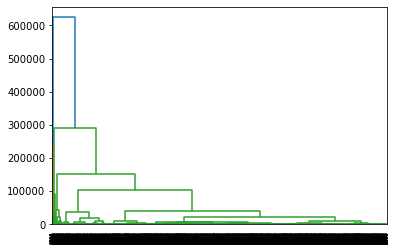

In [4]:
# Modelo de segmentación jerárquica
hierarchy_model = linkage(data, method='ward')

# Dendrograma
drendogram = dendrogram(hierarchy_model)

# Visualización del dendrograma
plt.show()

In [5]:
# Punto de corte
cluster_labels = fcluster(hierarchy_model, 9, criterion='distance')

hierarchicalData = corporateData.copy()

# Asignación de las etiquetas de clusters a los datos
hierarchicalData['ClusterLabels_H'] = cluster_labels

hierarchicalData = hierarchicalData.groupby('ClusterLabels_H').agg({'Recency':'mean',
                                                   'Frequency':'mean',
                                                   'MonetaryValue':['mean','count']})


hierarchicalData

NameError: name 'corporateData' is not defined